In [10]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [11]:
r = readers.CollectionReader('../src/beta_distribution/agents')

100%|██████████| 100/100 [00:04<00:00, 23.59it/s]


In [12]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [13]:
games =  ["MountainCarContinuous-v0", "Pendulum-v0", "InvertedPendulum-v2",
          "Humanoid-v2", "InvertedDoublePendulum-v2"]
code_level_opts = {
      'kl_penalty_coeff': [3],
      'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [14]:
#metadata['kl_penalty'] = (metadata['kl_penalty_coeff'] > 0)
code_level_opts = {'kl_penalty_direction': ['new_to_old', 'old_to_new']}
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot mean rewards

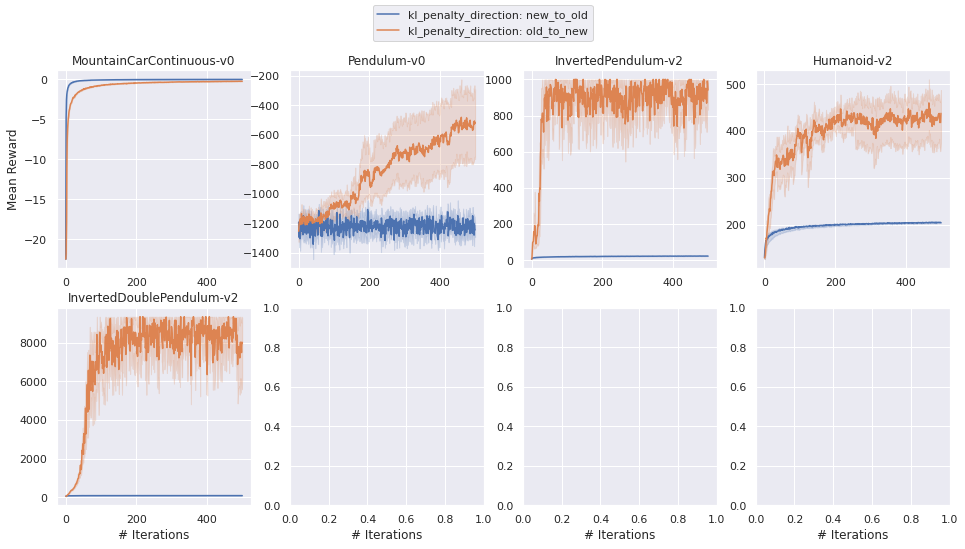

In [8]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
            sns.lineplot(filt.opt_step, filt.mean_reward,
                         ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

# Plot cumulative distribution of max rewards

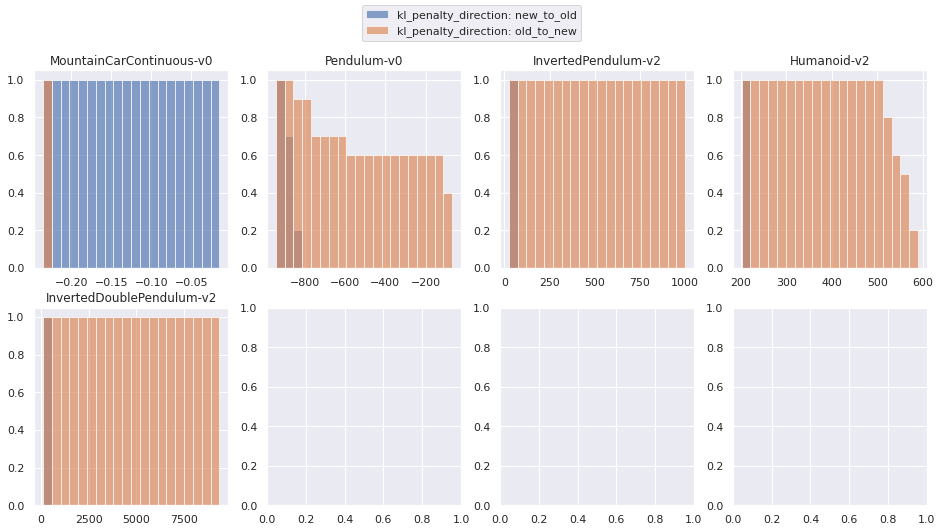

In [15]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax.flatten()[j].bar(bin_locs, hist, label=f"{cl_opt}: {b}",
                                **kwargs)
        ax.flatten()[j].set_title(g)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Plot distribution of max rewards

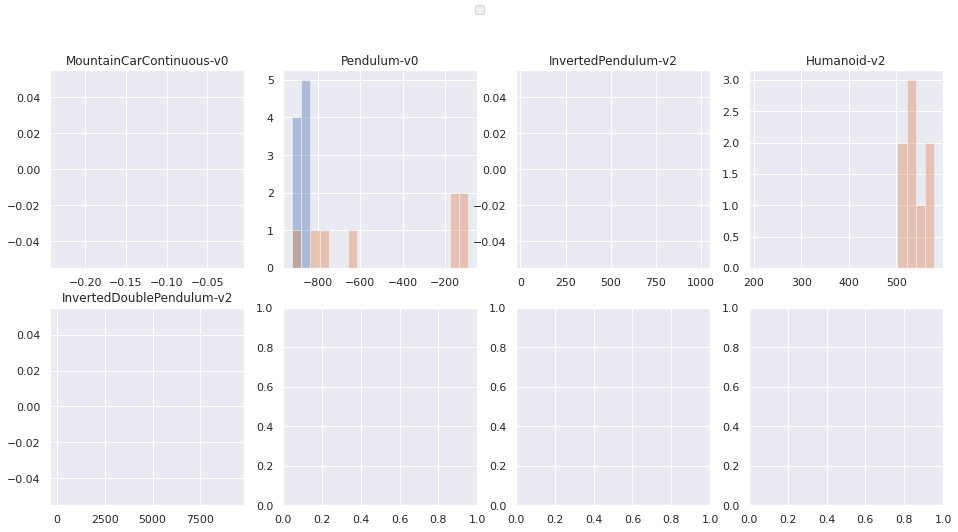

In [16]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Aggregate performance in normalized scores

In [17]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [18]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

index  mean_max_reward  \
game                      kl_penalty_direction                           
Humanoid-v2               new_to_old                0       207.782877   
                          old_to_new                1       546.289940   
InvertedDoublePendulum-v2 new_to_old                2        98.625152   
                          old_to_new                3      9342.176157   
InvertedPendulum-v2       new_to_old                4        24.807869   
                          old_to_new                5      1000.000000   
MountainCarContinuous-v0  new_to_old                6        -0.015275   
                          old_to_new                7        -0.232288   
Pendulum-v0               new_to_old                8      -882.598412   
                          old_to_new                9      -370.270538   

                                                    stddev  max_max_reward  \
game                      kl_penalty_direction                               
Humanoid-v2               new_to_old              2.070743      589.340515   
                          old_to_new             31.231683      589.340515   
InvertedDoublePendulum-v2 new_to_old              0.458517     9345.824177   
                          old_to_new              2.801487     9345.824177   
InvertedPendulum-v2       new_to_old              0.376390     1000.000000   
                          old_to_new              0.000000     1000.000000   
MountainCarContinuous-v0  new_to_old              0.000187       -0.015096   
                          old_to_new              0.001372       -0.015096   
Pendulum-v0               new_to_old             34.375027      -68.662083   
                          old_to_new            346.197811      -68.662083   

                                                min_max_reward  \
game                      kl_penalty_direction                   
Humanoid-v2               new_to_old                202.068217   
                          old_to_new                202.068217   
InvertedDoublePendulum-v2 new_to_old                 98.107671   
                          old_to_new                 98.107671   
InvertedPendulum-v2       new_to_old                 24.341463   
                          old_to_new                 24.341463   
MountainCarContinuous-v0  new_to_old                 -0.235396   
                          old_to_new                 -0.235396   
Pendulum-v0               new_to_old               -942.698824   
                          old_to_new               -942.698824   

                                                normalized_score  \
game                      kl_penalty_direction                     
Humanoid-v2               new_to_old                    0.014756   
                          old_to_new                    0.888836   
InvertedDoublePendulum-v2 new_to_old                    0.000056   
                          old_to_new                    0.999606   
InvertedPendulum-v2       new_to_old                    0.000478   
                          old_to_new                    1.000000   
MountainCarContinuous-v0  new_to_old                    0.999190   
                          old_to_new                    0.014112   
Pendulum-v0               new_to_old                    0.068762   
                          old_to_new                    0.654925   

                                                normalized_stddev  
game                      kl_penalty_direction                     
Humanoid-v2               new_to_old                     0.005347  
                          old_to_new                     0.080645  
InvertedDoublePendulum-v2 new_to_old                     0.000050  
                          old_to_new                     0.000303  
InvertedPendulum-v2       new_to_old                     0.000386  
                          old_to_new                     0.000000  
MountainCarContinuous-v0  new_to_old                     0.000850  
